## **EDA and Model Training**
#### Imports and configuration

In [1]:
import geopandas as gpd
import pandas as pd
from pickle import dump
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

pd.options.mode.chained_assignment = None
base_dir = "C:\\Users\\Chris\\co_cloudcover\\"
label_dir = base_dir + "data\\label\\"
raw_dir = base_dir + "data\\raw\\"
model_dir = base_dir + "models\\"

In [2]:
training_zones = gpd.read_file(label_dir + "training_selection.shp")
training_dates = list(set(training_zones['date']))

IC_202403 = gpd.read_parquet(raw_dir+"ImageCollection_202403")
IC_202403['date'] = IC_202403['time'].dt.strftime("%Y-%m-%d")

IC_202308 = gpd.read_parquet(raw_dir+"ImageCollection_202308")
IC_202308['date'] = IC_202308['time'].dt.strftime("%Y-%m-%d")

#### Extract label samples

In [3]:
columns = list(IC_202403.columns)
columns.append("class")
training_data = gpd.GeoDataFrame(data=None, columns=columns)

for zone in training_zones.itertuples():
    temp_IC = IC_202403[IC_202403['date'] == zone[2]]
    temp_IC_training = temp_IC[temp_IC.within(zone[4])]
    temp_IC_training["class"] = zone[3]
    print(f"{len(temp_IC_training)} training samples found in {zone[2]} data")
    training_data = pd.concat([temp_IC_training,training_data])
    
for zone in training_zones.itertuples():
    temp_IC = IC_202308[IC_202308['date'] == zone[2]]
    temp_IC_training = temp_IC[temp_IC.within(zone[4])]
    temp_IC_training["class"] = zone[3]
    print(f"{len(temp_IC_training)} training samples found in {zone[2]} data")
    training_data = pd.concat([temp_IC_training,training_data])

#remove NANs
training_data_dropna = training_data.dropna()

14585 training samples found in 2024-03-14 data


C:\Users\Chris\AppData\Local\Temp\ipykernel_23076\3814401404.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  training_data = pd.concat([temp_IC_training,training_data])


20683 training samples found in 2024-03-14 data
1558 training samples found in 2024-03-28 data
82245 training samples found in 2024-03-01 data
6115 training samples found in 2024-03-01 data
711 training samples found in 2024-03-01 data
4645 training samples found in 2024-03-02 data
17834 training samples found in 2024-03-09 data
5345 training samples found in 2024-03-23 data
0 training samples found in 2023-08-07 data
0 training samples found in 2023-08-13 data
0 training samples found in 2023-08-26 data
0 training samples found in 2023-08-25 data
0 training samples found in 2023-08-25 data
0 training samples found in 2024-03-14 data
0 training samples found in 2024-03-14 data
0 training samples found in 2024-03-28 data
0 training samples found in 2024-03-01 data
0 training samples found in 2024-03-01 data
0 training samples found in 2024-03-01 data
0 training samples found in 2024-03-02 data
0 training samples found in 2024-03-09 data
0 training samples found in 2024-03-23 data
68471 

In [4]:
classes = list(set(training_data_dropna['class']))
print("original training classes")
for training_class in classes:
    print(training_class,len(training_data_dropna[training_data_dropna['class']==training_class]))

features = [
    "sur_refl_b01",
    "sur_refl_b02",
    "sur_refl_b03",
    "sur_refl_b04",
    "sur_refl_b05",
    "sur_refl_b06",
    "sur_refl_b07",
]

X = training_data_dropna[features]
y = training_data_dropna["class"]


#print("\n\nbalanced training classes")
rus = RandomUnderSampler()
X_resampled,y_resampled = rus.fit_resample(X,y)

training_data_RUS = X_resampled
training_data_RUS['class'] = y_resampled
training_data_RUS = training_data_RUS.sample(frac=1).reset_index(drop=True)

print("\n\nAfter Resampling:")
for training_class in classes:
    print(training_class,len(training_data_RUS[training_data_RUS['class']==training_class]))

original training classes
cloud 15737
snow 24037
terrain 156831
snow_cloud 35268


After Resampling:
cloud 15737
snow 15737
terrain 15737
snow_cloud 15737


In [5]:
training_data_RUS

,sur_refl_b01,sur_refl_b02,sur_refl_b03,sur_refl_b04,sur_refl_b05,sur_refl_b06,sur_refl_b07,class
0,9580.0,9618.0,9413.0,9490.0,7375.0,3179.0,1683.0,snow_cloud
1,1258.0,3503.0,760.0,1251.0,3586.0,2810.0,1643.0,terrain
2,7154.0,6213.0,6924.0,7179.0,1635.0,492.0,289.0,snow
3,2961.0,3939.0,1416.0,2292.0,4650.0,4946.0,3502.0,terrain
4,9016.0,8981.0,8856.0,9011.0,6402.0,2951.0,1664.0,snow_cloud
...,...,...,...,...,...,...,...,...
62943,9380.0,8827.0,9215.0,9346.0,4473.0,818.0,246.0,snow
62944,9975.0,10068.0,9634.0,9854.0,7525.0,2742.0,1319.0,snow_cloud
62945,9154.0,9330.0,8695.0,8934.0,8255.0,6342.0,3968.0,cloud
62946,8769.0,8430.0,8413.0,8714.0,4345.0,936.0,362.0,snow


In [7]:
scaler=StandardScaler()

# Use fit and transform method 
scaler.fit(training_data_RUS[features])
X_scaled=scaler.transform(training_data_RUS[features])

X_scaled = pd.DataFrame(X_scaled, index=training_data_RUS[features].index, columns=training_data_RUS[features].columns)

X_scaled['class'] = training_data_RUS["class"]
X_scaled

,sur_refl_b01,sur_refl_b02,sur_refl_b03,sur_refl_b04,sur_refl_b05,sur_refl_b06,sur_refl_b07,class
0,1.061355,1.192313,1.061184,1.046939,1.187959,-0.063499,-0.238365,snow_cloud
1,-1.783816,-1.431874,-1.671330,-1.679898,-0.930601,-0.244520,-0.266203,terrain
2,0.231941,-0.268907,0.275187,0.282074,-2.021471,-1.381662,-1.208518,snow
3,-1.201585,-1.244769,-1.464173,-1.335362,-0.335682,0.803339,1.027566,terrain
4,0.868532,0.918951,0.885290,0.888405,0.643921,-0.175349,-0.251588,snow_cloud
...,...,...,...,...,...,...,...,...
62943,0.992978,0.852864,0.998658,0.999279,-0.434648,-1.221736,-1.238444,snow
62944,1.196400,1.385426,1.130973,1.167410,1.271829,-0.277878,-0.491691,snow_cloud
62945,0.915712,1.068721,0.834448,0.862921,1.679997,1.488176,1.351878,cloud
62946,0.784086,0.682495,0.745396,0.790108,-0.506218,-1.163849,-1.157714,snow


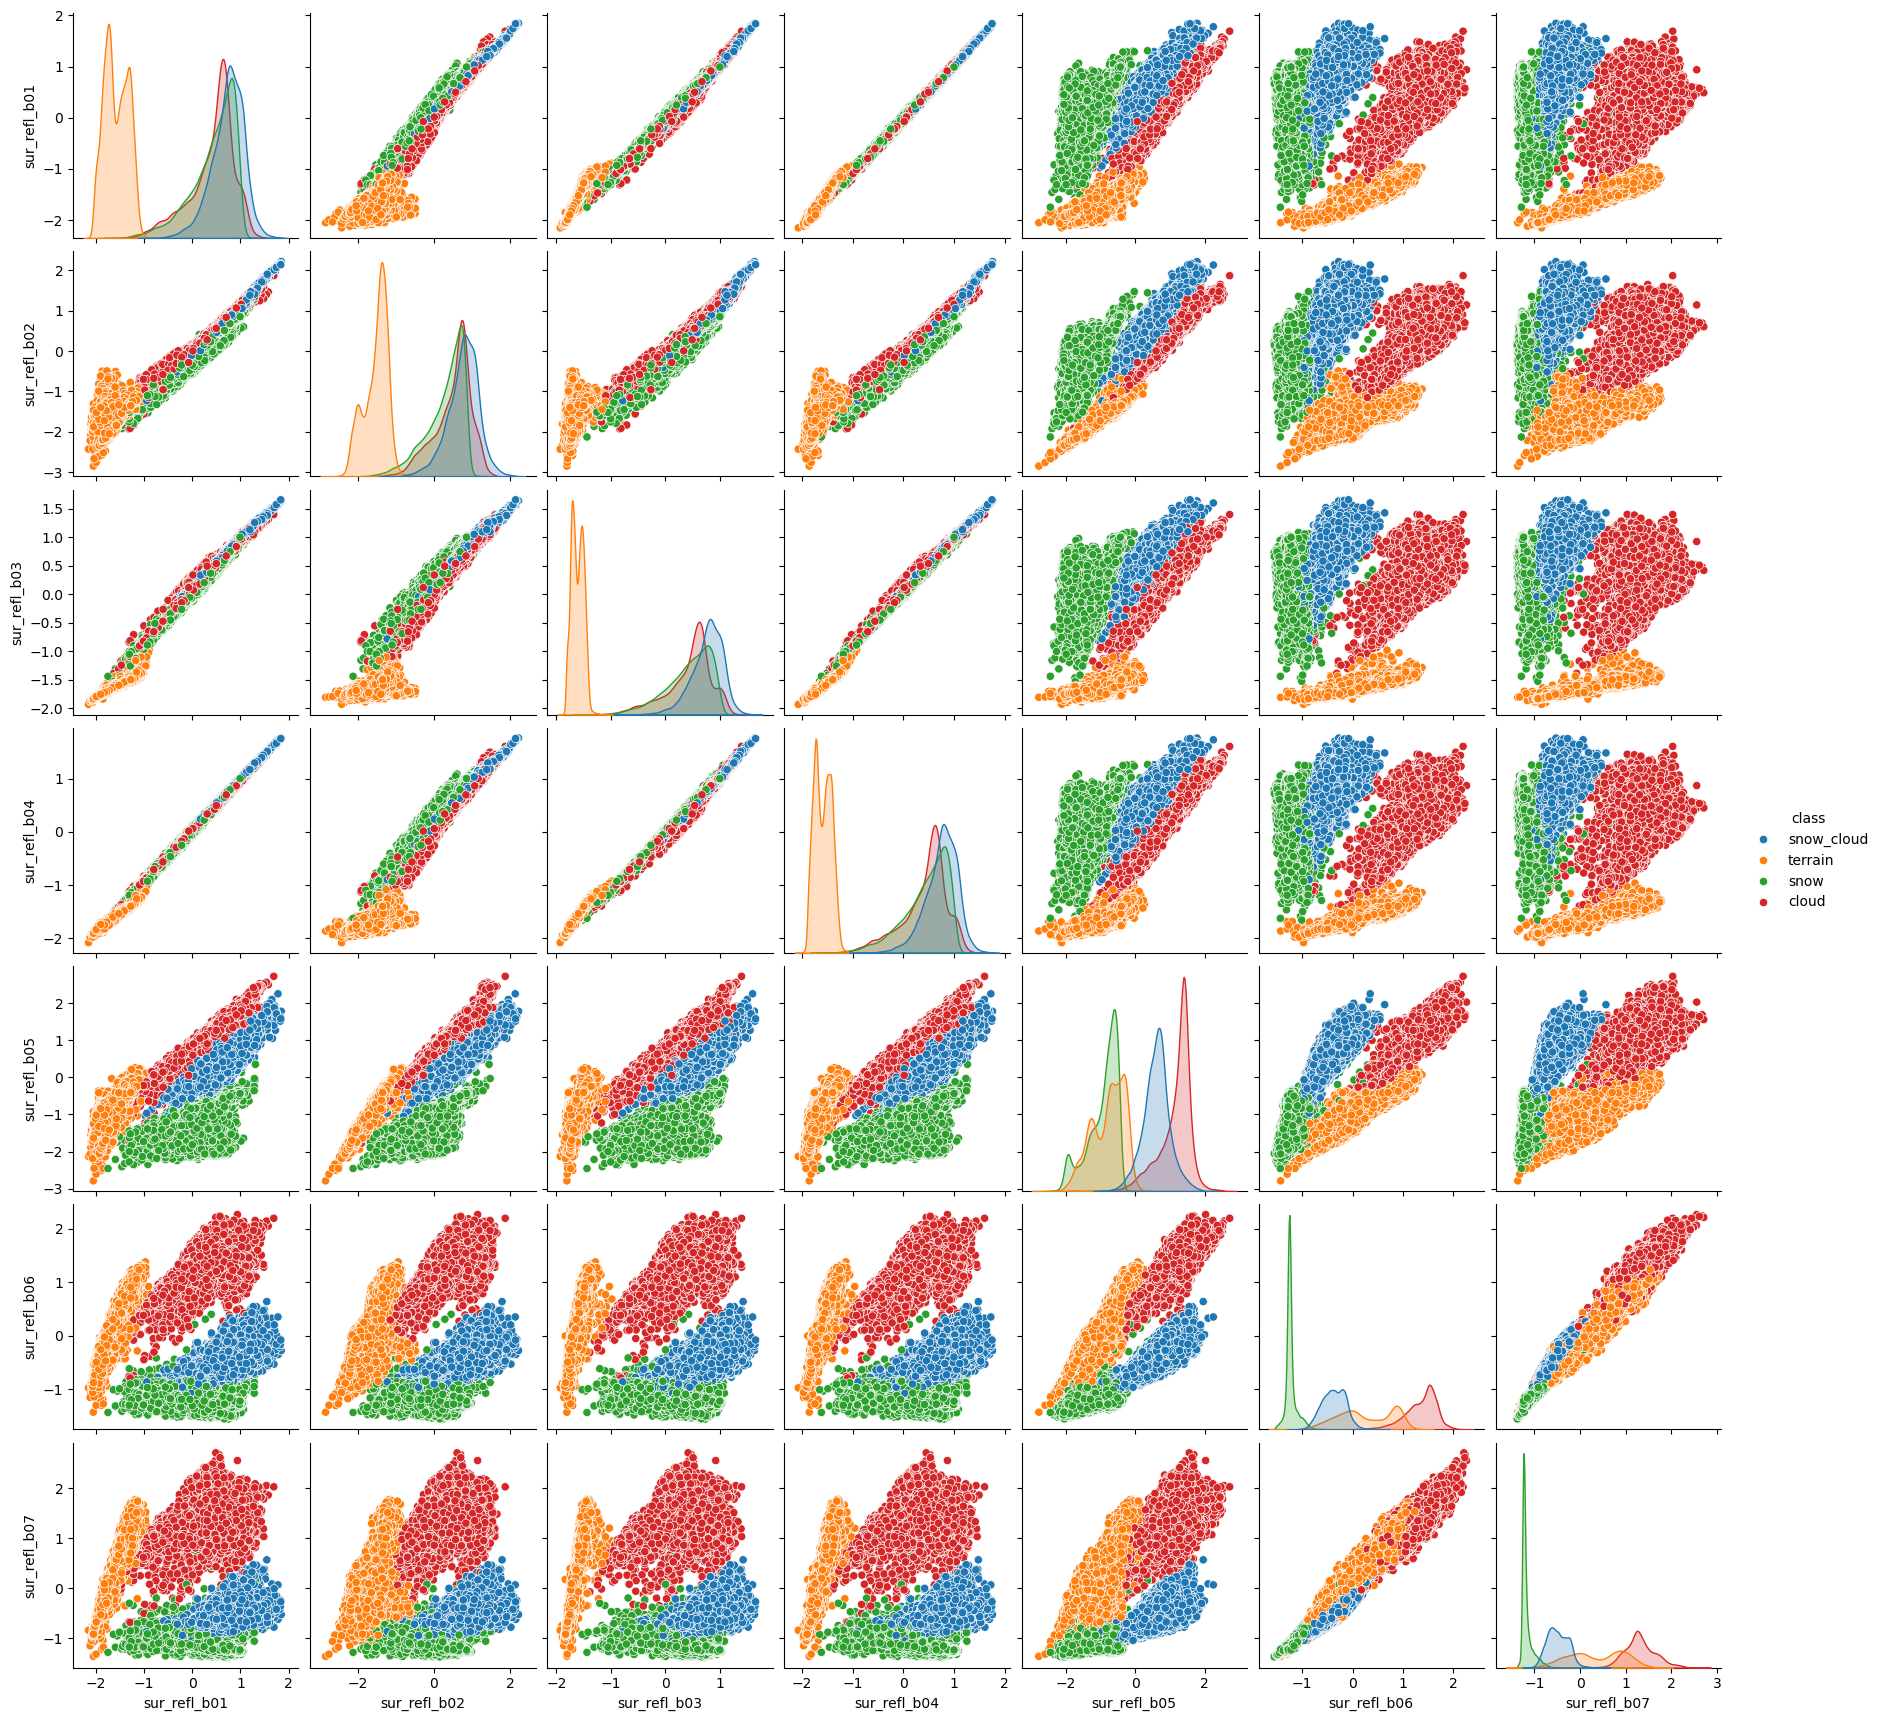

In [8]:
sns.pairplot(X_scaled, hue="class")

In [26]:
pca = PCA(n_components=6)
pca.fit(X_scaled[features])
print(pca.explained_variance_ratio_)

print(pca.components_)

[6.2774879e-01 3.5520402e-01 1.4052782e-02 1.7024925e-03 8.2635693e-04
 4.3134388e-04]
[[-0.47198626 -0.4746211  -0.4710091  -0.47193262 -0.3255421  -0.00389109
   0.03743486]
 [-0.07213588 -0.01983612 -0.08335418 -0.08140178  0.43643147  0.63220483
   0.6250391 ]
 [ 0.2525121  -0.09164219  0.2012048   0.21145436 -0.78014344  0.1707682
   0.45261177]
 [-0.02833612  0.82392687 -0.4914342  -0.14840996 -0.22596264  0.02340033
   0.07212178]
 [ 0.09826528 -0.04186864 -0.09983468 -0.03539481  0.19398165 -0.74953425
   0.6147689 ]
 [-0.7698326   0.27199888  0.54678345  0.01421813 -0.07480154 -0.0932477
   0.14110205]]


[0.6277486  0.35520387]


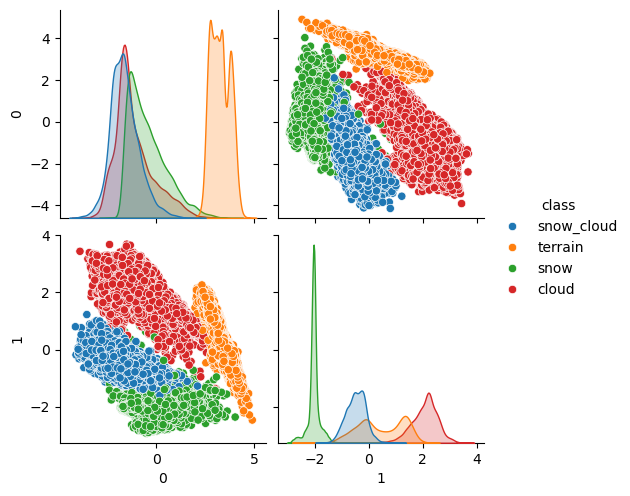

In [18]:
pca = PCA(n_components=2)
pca.fit(X_scaled[features])
print(pca.explained_variance_ratio_)

X_pca=pca.transform(X_scaled[features])
X_pca_wLabels = pd.DataFrame(X_pca, index=X_scaled[features].index)
X_pca_wLabels['class'] = X_scaled['class']
sns.pairplot(X_pca_wLabels, hue="class")

Accuracy: 0.9926288364999682
Accuracy: 0.9923111139353117
Accuracy: 0.9918027578318612
Accuracy: 0.9932642816292813


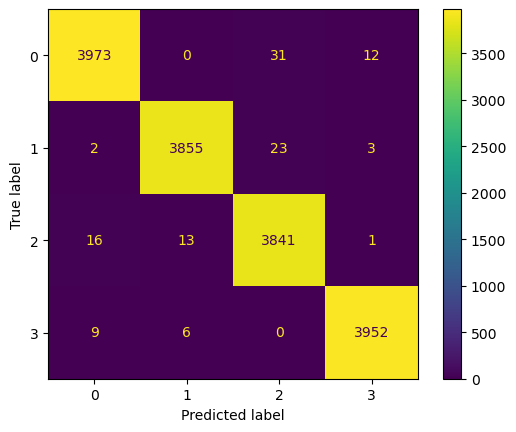

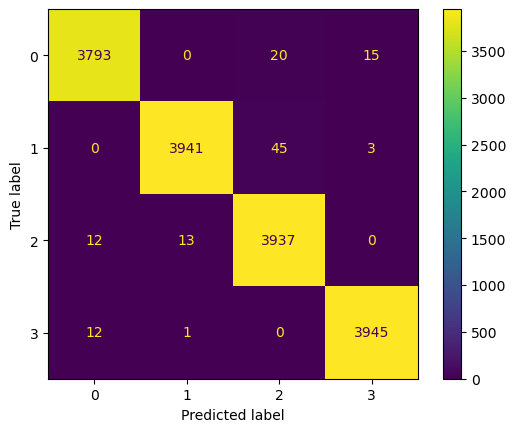

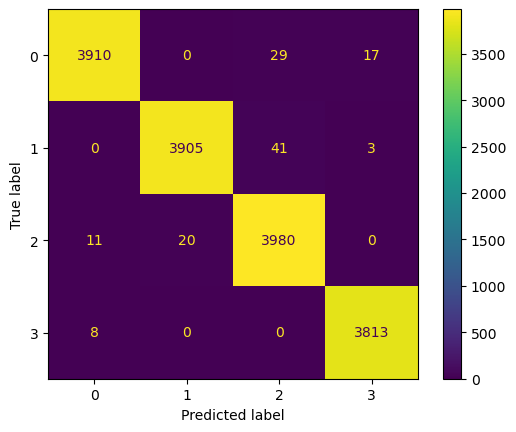

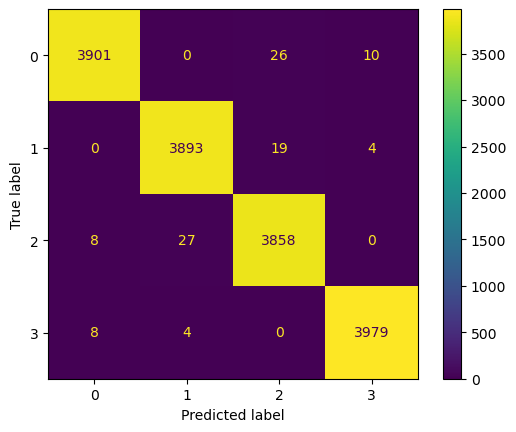

In [19]:
kf = KFold(n_splits=4)
for train, test in kf.split(X_pca_wLabels):
    X_train = X_pca[train]
    X_test = X_pca[test]
    y_train = X_pca_wLabels["class"].iloc[train]
    y_test = X_pca_wLabels["class"].iloc[test]
    #print(X_train, X_test, y_train, y_test)
    
    rfc = RandomForestClassifier(max_depth=2)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot();
    


In [20]:
rfc = RandomForestClassifier(max_depth=2)
rfc.fit(X_pca, X_pca_wLabels["class"])
y_pred = rfc.predict(X_pca)

In [23]:
accuracy = accuracy_score(X_pca_wLabels["class"], y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.989626358263964


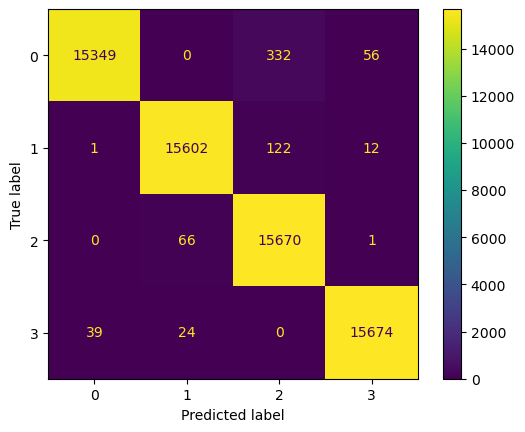

In [21]:
cm = confusion_matrix(X_pca_wLabels["class"], y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();


In [25]:
with open(model_dir + "rfc_20240529.pkl", "wb") as f:
    dump(rfc, f, protocol=5)
with open(model_dir + "pca_20240529.pkl", "wb") as f:
    dump(pca, f, protocol=5)
with open(model_dir + "scaler_20240529.pkl", "wb") as f:
    dump(scaler, f, protocol=5)



<Axes: >

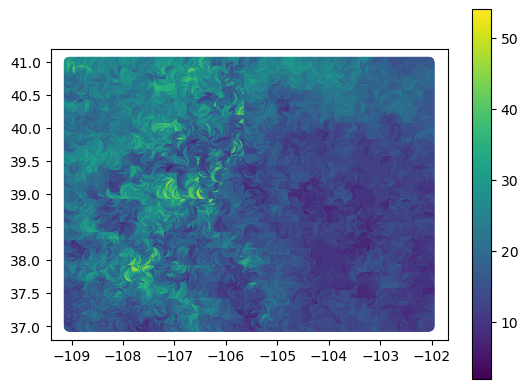

In [ ]:
from pickle import load
with open(model_dir + "rfc_20240527.pkl", "rb") as f:
    rfc1 = load(f)

IC_2022 = gpd.read_parquet(raw_dir+"ImageCollection_2022.parquet")
IC_2022['date'] = IC_2022['time'].dt.strftime("%Y-%m-%d")

IC_2022["prediction"] = rfc1.predict(IC_2022[features])

cloud_count_2022 = IC_2022[IC_2022["prediction"]=="snow_cloud"].\
    groupby(['geometry']).\
    agg("count").\
    reset_index()\
    [["prediction","geometry"]]

gdf = gpd.GeoDataFrame(cloud_count_2022)
gdf.plot(column="clouds",legend=True)